# Backup Coverage Location Problem（BCLP）

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Description" data-toc-modified-id="Problem-Description-0">Problem Description</a></span><ul class="toc-item"><li><span><a href="#BCLP" data-toc-modified-id="BCLP-0.1">BCLP</a></span></li><li><span><a href="#Integer-programming-model:" data-toc-modified-id="Integer-programming-model:-0.2">Integer programming model:</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-1">Setup</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-2">Example</a></span><ul class="toc-item"><li><span><a href="#Random-Data" data-toc-modified-id="Random-Data-2.1">Random Data</a></span></li><li><span><a href="#Road-Network-Data" data-toc-modified-id="Road-Network-Data-2.2">Road Network Data</a></span></li></ul></li></ul></div>

## Problem Description

### BCLP
In the coverage-based location model, demand is considered "covered" only when it is completely within the coverage area of the facility. The backup Coverage Location Problem considers that a secondary (or alternate) facility that covers the demand point is provided to ensure the demand point is served when the first cover facility is unavailable. Under budget constraints, primary and secondary coverage can be formulated as a multi-objective optimization problem called BCLP.


*Parameters*:

* **$i$** : Index of demand, $i = 1,..., n$
* **$j$** : Index of potential facility location, $j = 1,..., m$
* **$ N_i $** : {$j$ | $λ_{ij} = 1$}
* **$ a_i $** : Importance of demand $i$
* **$ p $** : Number of facilities to be located


*Decision variables*:
$
$\begin{array}
$ x_j= \begin{cases}1, & \text { if a facility is located at } j, \\ 0, & \text { else }\end{cases}\\
 y_i= \begin{cases}1, & \text { if demand } i \text{ is covered by a sited facility }, \\ 0, & \text { else }\end{cases}\\
 u_i= \begin{cases}1, & \text { if demand } i \text{ is covered twice }, \\ 0, & \text { else }\end{cases}\\
 λ_{i j}= \begin{cases}1, & \text { if demand } i \text { is covered by a potential facility } j, \\ 0, & \text { else }\end{cases}
\end{array}$
$

###  Integer programming model:

\begin{array}{lll}
\max & Z_{1}=\sum_{i}{a_iy_i} && (1)\\
\max & Z_{2}=\sum_{i}{a_iu_i} && (2)\\
\text { s.t. } & \sum_{j\in N_i}{x_j-y_i-u_i \geq 0} & \forall i & (3)\\
            & u_i-y_i \leqslant 0 & \forall i & (4)\\
            & \sum_{j}{x_j = p} &&  (5)\\
            & x_j = \{0,1\} & \forall j & (6)\\
            & y_i, u_i = \{0,1\} & \forall i & (7)\\
\end{array}
        

## Setup

In [1]:
import random
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import osmnx as ox
from location.CModel import *

## Example

### Random Data

In [2]:
np.random.seed(0) # random seed
random.seed(0)
solver_list = listSolvers(onlyAvailable=True)
print(solver_list)  

No parameters matching '_test' found
['CPLEX_CMD', 'GUROBI', 'GUROBI_CMD', 'PULP_CBC_CMD']


In [3]:
radius = 0.2
num_points = 20
num_facilities = 5
setup_cost = np.random.randint(6, size=num_points)
points = [(random.random(), random.random()) for i in range(num_points)]
points_np = np.array(points)
A = np.sum((points_np[:, np.newaxis, :] - points_np[np.newaxis, :, :]) ** 2, axis = -1) ** 0.5
mask = A <= radius
A[mask] = 1
A[~mask] = 0
selected, served_once, served_twice, obj = BackupCoveringModel(num_points=num_points, 
                                                               num_facilities=num_facilities,
                                                               setup_cost=setup_cost,
                                                               cover=A,
                                                               solver=PULP_CBC_CMD()).prob_solve()

Status: Optimal
Selected position =  [3, 7, 9, 10, 13]
Served once =  [0, 1, 3, 4, 6, 7, 8, 9, 10, 13, 14, 18]
Served twice =  [3, 7, 10, 13, 18]
Max served number =  60.0


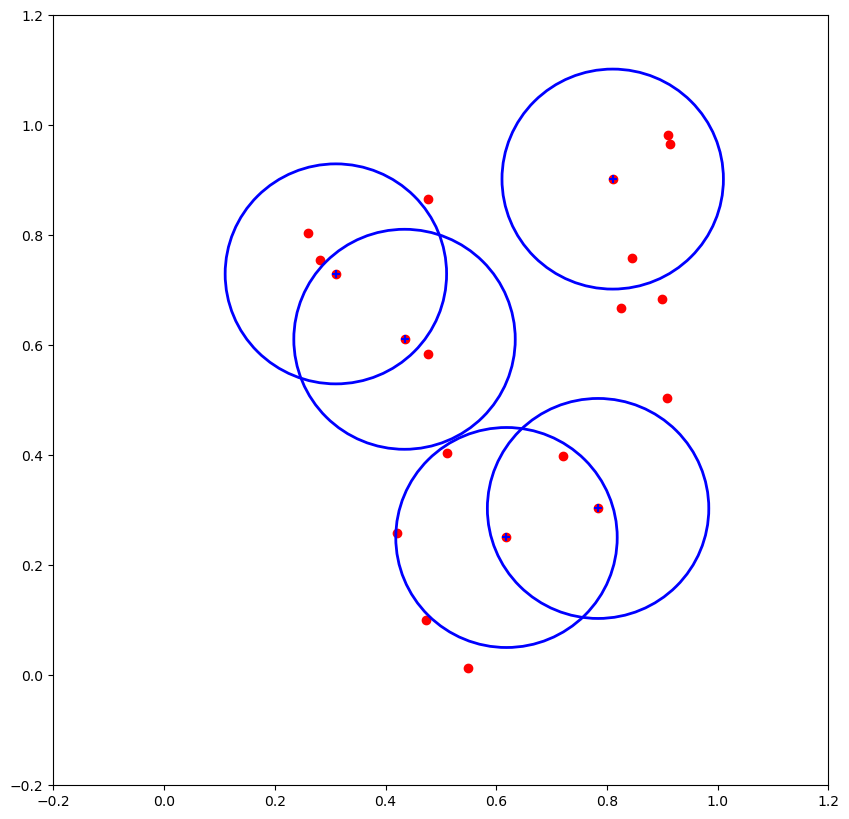

In [4]:
def display_points_with_mclp(data, ax,solution, radius):
    ax = plt.gca()
    plt.xlim(-0.2, 1.2)
    plt.ylim(-0.2, 1.2)
    plt.scatter(data[:, 0], data[:, 1], c='red')
    for i in solution:
        plt.scatter(data[i][0], data[i][1], c='blue', marker='+')
        circle = Circle(xy=(data[i][0], data[i][1]), radius=radius, color='b', fill=False, lw=2)
        ax.add_artist(circle)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
display_points_with_mclp(points_np, ax1, selected, radius)

### Road Network Data

In [5]:
df = pd.read_csv('../data/北京POI裁剪.csv',encoding='gbk')
df = df.query('adname=="东城区" | adname=="西城区" | adname=="朝阳区" | adname=="海淀区"').reset_index(drop=True)
data = df[['long', 'lat']]
num_points = df.shape[0]
num_facilities = 25
np.random.seed(0)
setup_cost = np.random.randint(6, size=num_points)
points = [(data['long'][i], data['lat'][i]) for i in range(num_points)]

In [6]:
radius = 0.03
points_np = np.array(points)
A = np.sum((points_np[:, np.newaxis, :] - points_np[np.newaxis, :, :]) ** 2, axis = -1) ** 0.5
mask = A <= radius
A[mask] = 1
A[~mask] = 0

In [7]:
selected, served_once, served_twice, obj = BackupCoveringModel(num_points=num_points, 
                                                               num_facilities=num_facilities,
                                                               setup_cost=setup_cost,
                                                               cover=A,
                                                               solver=PULP_CBC_CMD()).prob_solve()

Status: Optimal
Selected position =  [7, 9, 17, 24, 25, 27, 32, 39, 45, 53, 55, 65, 69, 70, 71, 76, 81, 87, 89, 90, 91, 95, 98, 101, 111]
Served once =  [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 17, 18, 19, 20, 23, 24, 26, 27, 29, 30, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102, 103, 105, 106, 107, 109, 111, 112, 114, 115, 116, 117]
Served twice =  [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 17, 18, 19, 20, 23, 24, 27, 29, 30, 32, 33, 34, 35, 36, 38, 39, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 93, 94, 95, 96, 98, 100, 101, 102, 103, 105, 106, 107, 109, 111, 112, 114, 115, 116, 117]
Max served number =  540.0


In [8]:
def display_mclp_with_road_network(data, solution, radius):
    for j in range(num_points):
        if j in selected:
            lx = df['lat'][j]
            ly = df['long'][j]
            plt.plot(ly,lx,c='red',marker='*',markersize=50, zorder=3)
        else:
            lx = df['lat'][j]
            ly = df['long'][j]
            plt.plot(ly,lx,c="black",marker='o',markersize=20, zorder=2)
    ax = plt.gca()
    for i in solution:
        circle = Circle(xy=(data[i][0], data[i][1]), radius=radius, color='#1E90FF', fill=False, lw=5)
        ax.add_artist(circle)
    plt.axis('equal')

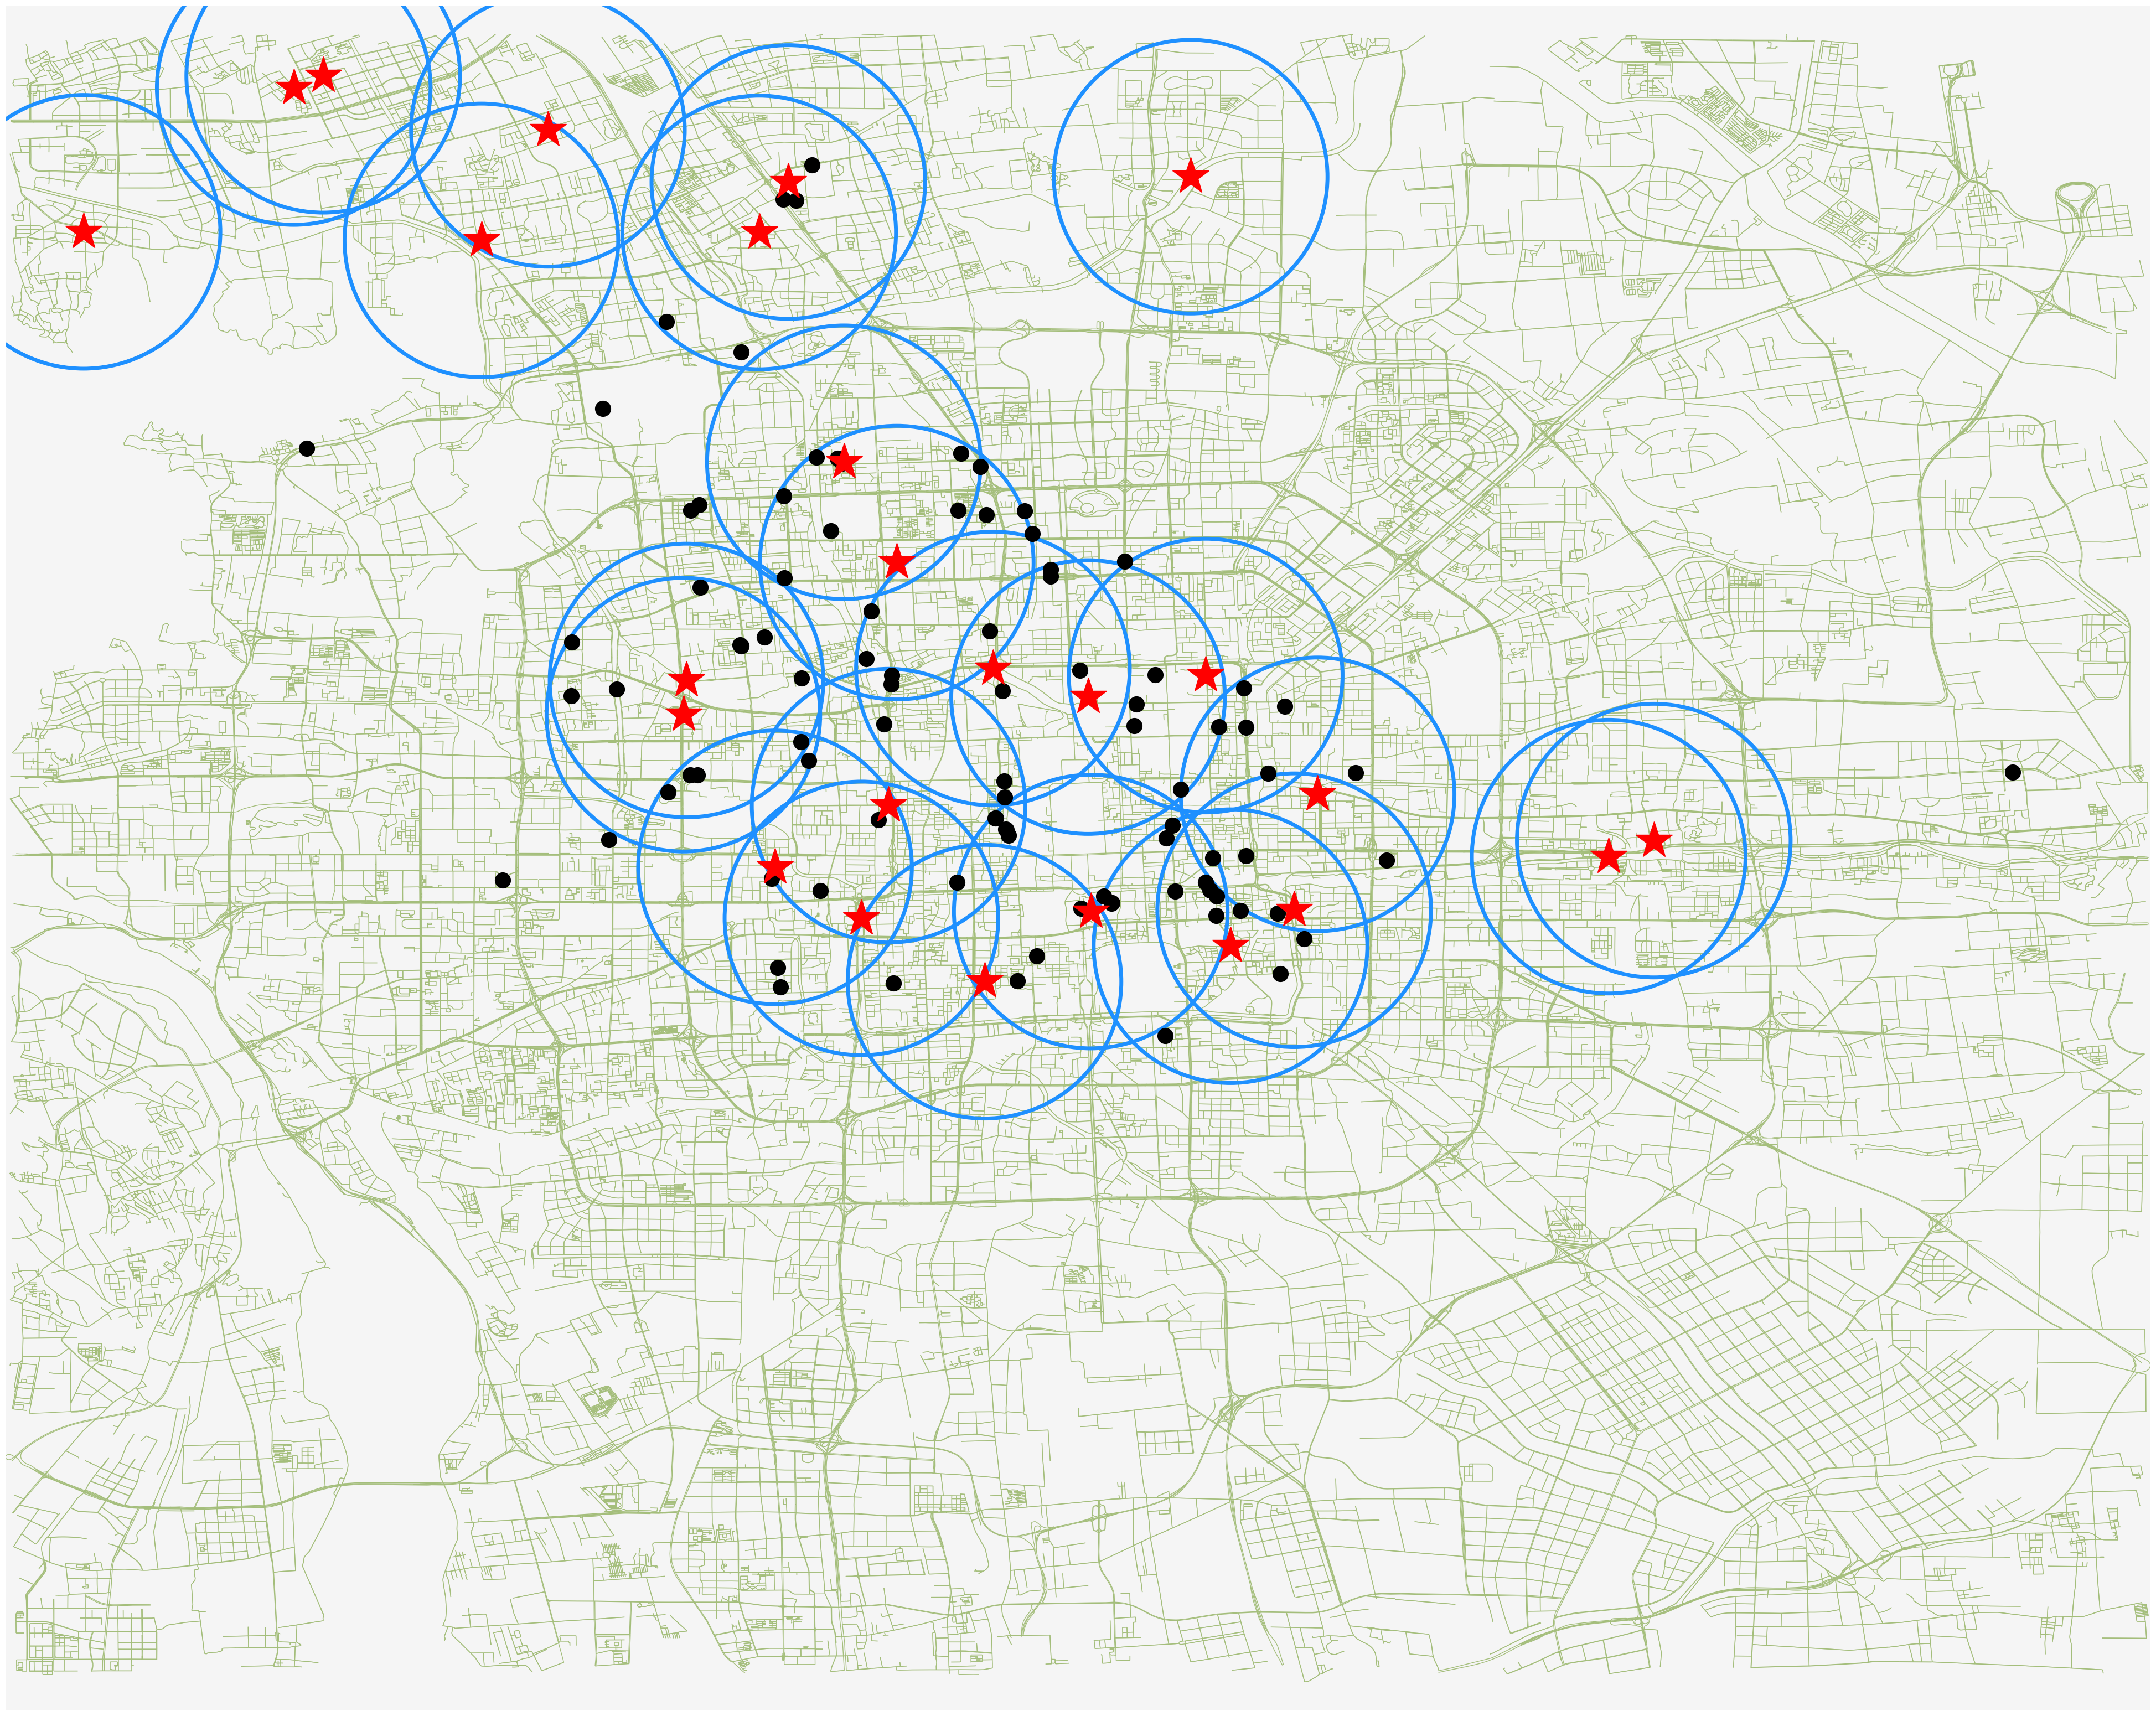

In [9]:
G = ox.load_graphml('..\data\Beijing.graphml')
ox.plot_graph(G, figsize=(50,40),bgcolor="#F5F5F5",node_size=0,edge_color = "#A4BE7B", show=False, close=False)
display_mclp_with_road_network(points_np, selected, radius)